<div class="alert alert-block alert-warning">

<h1>Twitter Financial News</h1>
    
<a href="https://www.kaggle.com/datasets/sulphatet/twitter-financial-news?select=train_data.csv">Kaggle Link</a>

    
<h2>About Dataset</h2>
<blockquote>The Twitter Financial News dataset is an English-language dataset containing an annotated corpus of finance-related tweets. This dataset is used to classify finance-related tweets for their topic.</blockquote>

<p>Ideas</p>
<blockquote>
<ul>
    <li>The data is a multi-label text classification problem with imbalanced data.</li>
    <li>The links within the texts could be extracted.</li>
    <li>EDA</li>
</ul>
</blockquote>
</div>

<hr>

<div class="alert alert-block alert-info">
    <h2>Labels</h2>
    <p><strong>0:</strong> Analyst Update.</p>
    <p><strong>1</strong> Fed | Central Banks.</p>
    <p><strong>2:</strong> Company | Product News.</p>
    <p><strong>3:</strong> Treasuries | Corporate Debt</p>
    <p><strong>4:</strong> Dividend</p>
    <p><strong>5:</strong> Earnings</p>
    <p><strong>6:</strong> Energy | Oil</p>
    <p><strong>7:</strong> Financials</p>
    <p><strong>8:</strong> Currencies</p>
    <p><strong>9:</strong> General News | Opinion</p>
    <p><strong>10:</strong> Gold | Metals | Materials</p>
    <p><strong>11:</strong> IPO</p>
    <p><strong>12:</strong> Legal | Regulation</p>
    <p><strong>13:</strong> MA | Investments</p>
    <p><strong>14:</strong> Macro</p>
    <p><strong>15:</strong> Markets</p>
    <p><strong>16:</strong> Politics</p>
    <p><strong>17:</strong> Personnel Change</p>
    <p><strong>18:</strong> Stock Commentary</p>
    <p><strong>19:</strong> Stock Movement</p>
</div>

In [1]:
label = {
    0:'Analyst Update',
    1:'Fed|Central Banks',
    2:'Company|Product News',
    3:'Treasures|Corporate Dept',
    4:'Dividend',
    5:'Earnings',
    6:'Energy|Oil',
    7:'Financials',
    8:'Currencies',
    9:'General News|Opinion',
    10:'Gold|Metals|Materials',
    11:'IPO',
    12:'Legal|Regulation',
    13:'MA|Investment',
    14:'Macro',
    15:'Markets',
    16:'Politics',
    17:'Personnel Change',
    18:'Stock Commentary',
    19:'Stock Movement',
}

## Importing Libraries and Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score,classification_report

In [5]:
train = pd.read_csv('train_data.csv')
valid = pd.read_csv('valid_data.csv')

## EDA

In [6]:
df = pd.concat([train,valid]).reset_index()
df = df.drop('index',axis = 1)

In [7]:
def link_count(text):
    text = text.lower().split(' ')
    count = 0
    for word in text:
        if word[0:4] == 'http':
            count +=1
    return count

In [8]:
def extract_links(text):
    text = text.lower().split(' ')
    c = []
    for word in text:
        if word[0:4] != 'http':
            c.append(word)
    return ' '.join(c)

In [9]:
df['total_link'] = df['text'].apply(link_count)

In [10]:
df['text'] = df['text'].apply(extract_links)

In [11]:
df['text_length'] = df['text'].apply(len)

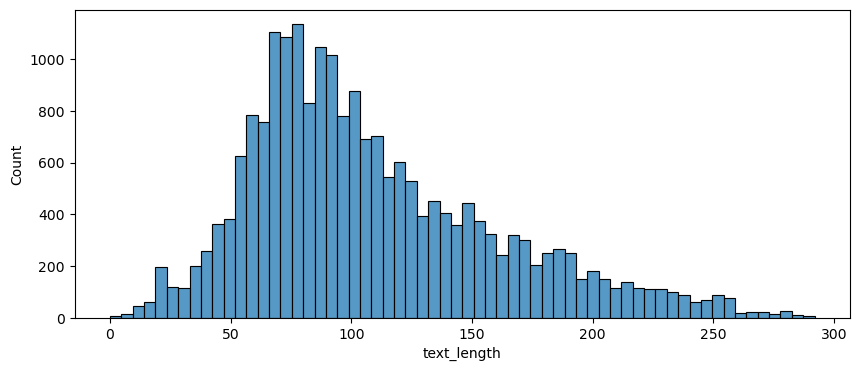

In [12]:
plt.figure(figsize = (10,4))
sns.histplot(x = 'text_length',data = df)
plt.show()

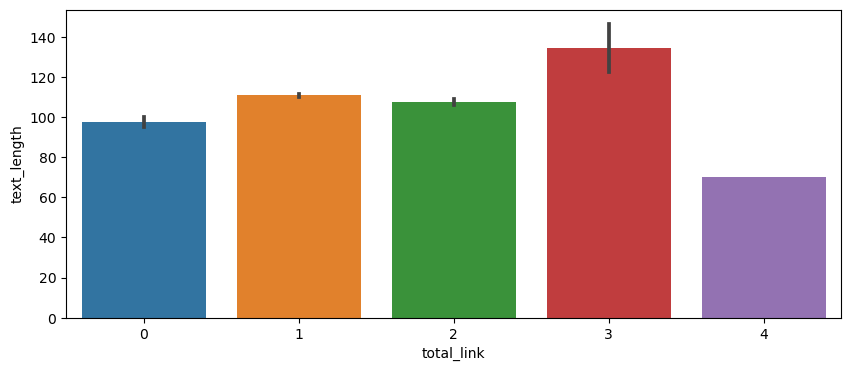

In [13]:
plt.figure(figsize = (10,4))
sns.barplot(x = 'total_link',y = 'text_length',data = df)
plt.show()

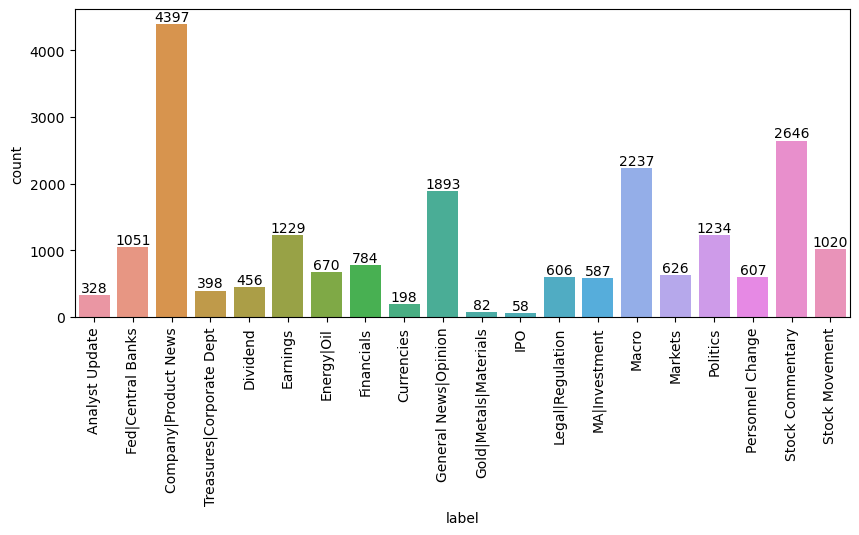

In [14]:
plt.figure(figsize = (10,4))
ax = sns.countplot(x = 'label',data = df)
ax.bar_label(ax.containers[0])
plt.xticks(ticks=np.arange(0,20),labels=list(label.values()),rotation = 'vertical')
plt.show()

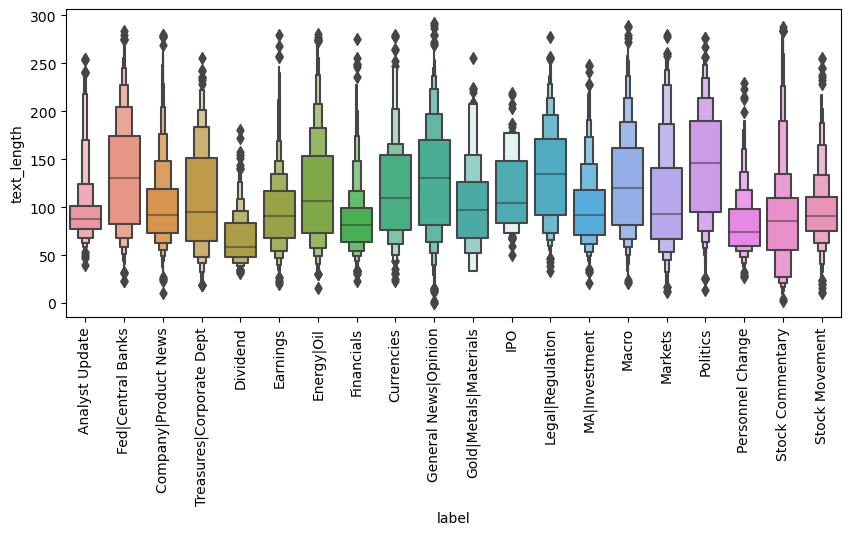

In [15]:
plt.figure(figsize = (10,4))

sns.boxenplot(x = 'label',y = 'text_length',data = df)
plt.xticks(ticks=np.arange(0,20),labels=list(label.values()),rotation = 'vertical')
plt.show()

## NLP

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
ps = PorterStemmer()

In [18]:
def nlp(text):
    text = re.sub('[^a-zA-Z]',' ',text)
    text = text.lower().split(' ')
    c = []
    for word in text:
        if word[0:4] == 'http':
            break        
        elif not word in set(all_stopwords):
            c.append(ps.stem(word))
    text = ' '.join(c).strip()
    return text

In [19]:
train['text'] = train['text'].apply(nlp)
valid['text'] = valid['text'].apply(nlp)

## Creating Train and Test Sets

In [20]:
X_train = train['text']
y_train = train['label']

X_test = valid['text']
y_test = valid['label']

## Count Vectorizer

In [21]:
cv = CountVectorizer(max_features=2000)
X_train = cv.fit_transform(X_train).toarray()
X_test = cv.transform(X_test).toarray()

## LightGBM Classifier

In [22]:
lgbm_model = LGBMClassifier().fit(X_train,y_train)
lgbm_pred = lgbm_model.predict(X_test)

In [23]:
print(round(accuracy_score(y_test,lgbm_pred),2))

0.81


In [24]:
print(classification_report(y_test,lgbm_pred))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67        73
           1       0.85      0.86      0.86       214
           2       0.78      0.86      0.82       852
           3       0.94      0.78      0.85        77
           4       0.95      0.99      0.97        97
           5       0.90      0.93      0.91       242
           6       0.80      0.84      0.82       146
           7       0.84      0.84      0.84       160
           8       0.78      0.91      0.84        32
           9       0.74      0.64      0.68       336
          10       0.57      0.62      0.59        13
          11       0.87      0.93      0.90        14
          12       0.90      0.80      0.84       119
          13       0.82      0.66      0.73       116
          14       0.80      0.82      0.81       415
          15       0.85      0.74      0.79       125
          16       0.94      0.89      0.91       249
          17       0.86    

## Single Predictions

In [26]:
count = 1
while True:
    print('\n')
    print(f'Prediction {count}'.center(50,'_'))
    text = input('Enter text (-1 to exit):\n')
    if text == '-1':
        break
    text = nlp(text)
    prediction = label[lgbm_model.predict(cv.transform([text]).toarray())[0]]
    print('\nThe predicted label is:',prediction)
    count +=1



___________________Prediction 1___________________
Enter text (-1 to exit):
Tesla gross profit for the twelve months ending December 31, 2022 was $20.853B, a 53.26% increase year-over-year. Tesla annual gross profit for 2022 was $0B, a 100% decline from 2021. Tesla annual gross profit for 2021 was $13.606B, a 105.22% increase from 2020.

The predicted label is: Financials


___________________Prediction 2___________________
Enter text (-1 to exit):
Buying Amazon stock requires you to have a brokerage account, and online brokers offer the quickest and easiest ways to start one today. If you don't have a brokerage account, you can open one in about 15 minutes — the process is similar to signing up for a checking or savings account.

The predicted label is: Company|Product News


___________________Prediction 3___________________
Enter text (-1 to exit):
Tesla net income for the quarter ending December 31, 2022 was $3.687B, a 58.85% increase year-over-year. Tesla net income for the twel